In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 323029, done.
remote: Counting objects: 100% (1000/1000), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 323029 (delta 777), reused 957 (delta 748), pack-reused 322029
Receiving objects: 100% (323029/323029), 655.31 MiB | 17.81 MiB/s, done.
Resolving deltas: 100% (296846/296846), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

import sys
sys.path.append('/content/')

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler


In [ ]:
!unzip /content/drive/MyDrive/VisDrone2019-DET-test-dev.zip
!unzip /content/drive/MyDrive/VisDrone2019-DET-val.zip

Archive:  /content/drive/MyDrive/VisDrone2019-DET-test-dev.zip
   creating: annotations/
  inflating: annotations/0000006_00159_d_0000001.txt  
  inflating: annotations/0000006_00611_d_0000002.txt  
  inflating: annotations/0000006_01111_d_0000003.txt  
  inflating: annotations/0000006_01275_d_0000004.txt  
  inflating: annotations/0000006_01659_d_0000004.txt  
  inflating: annotations/0000006_02138_d_0000006.txt  
  inflating: annotations/0000006_02616_d_0000007.txt  
  inflating: annotations/0000006_03636_d_0000009.txt  
  inflating: annotations/0000006_04050_d_0000010.txt  
  inflating: annotations/0000006_04309_d_0000011.txt  
  inflating: annotations/0000006_05168_d_0000013.txt  
  inflating: annotations/0000006_05208_d_0000014.txt  
  inflating: annotations/0000006_05575_d_0000016.txt  
  inflating: annotations/0000006_05999_d_0000017.txt  
  inflating: annotations/0000006_06773_d_0000018.txt  
  inflating: annotations/0000006_07596_d_0000020.txt  
  inflating: annotations/000001

In [ ]:
files_dir_train = '/content/VisDrone2019-DET-val/'
files_dir_test = '/content/VisDrone2019-DET-test-dev/'

In [ ]:
class VisDroneDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir,ann_dir, width, height, transforms=None):
        self.transforms = transforms
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(img_dir))
                        if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'pedestrian','people','bicycle', 
                        'car','van','truck','tricycle','awning-tricycle','bus','motor']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.img_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # dividing by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.ann_dir, annot_filename)
        
        boxes = []
        labels = []
        
        
        with open(annot_file_path, 'r') as f:
            for line in f:
                box = [float(x) for x in line.strip().split(',')]
                labels.append(int(box[5]))
                
                xmin, ymin, w, h = box[:4]
                xmax = xmin + w
                ymax = ymin + h
                
                xmin_corr = (xmin/img.shape[1])*self.width
                xmax_corr = (xmax/img.shape[1])*self.width
                ymin_corr = (ymin/img.shape[0])*self.height
                ymax_corr = (ymax/img.shape[0])*self.height
                
                boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # target["masks"] = torch.zeros((boxes.shape[0], self.height, self.width), dtype=torch.uint8)
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)
  

In [ ]:
# check dataset
dataset_train = VisDroneDataset(files_dir_train+'/images',files_dir_train+'/annotations', 1224, 724)
dataset_test= VisDroneDataset('/content/images','/content/annotations', 1224, 724)
print('length of training dataset = ', len(dataset_train), '\n')
print('length of testing dataset = ', len(dataset_test), '\n')

length of training dataset =  548 

length of testing dataset =  1610 



In [ ]:
# getting the image and target for a test index
img1, target = dataset_train[1]
img, target = dataset_test[0]
print(img.shape, '\n',target)

(724, 1224, 3) 
 {'boxes': tensor([[6.1650e+02, 4.3819e+02, 7.1550e+02, 4.9970e+02],
        [5.2020e+02, 3.1042e+02, 5.5260e+02, 3.4638e+02],
        [5.5530e+02, 3.0947e+02, 5.8950e+02, 3.5112e+02],
        [5.9310e+02, 3.3124e+02, 6.7410e+02, 3.6910e+02],
        [6.8490e+02, 3.2746e+02, 7.2090e+02, 3.6910e+02],
        [7.2450e+02, 3.3124e+02, 7.5870e+02, 3.7004e+02],
        [7.6410e+02, 3.2746e+02, 8.0460e+02, 3.7194e+02],
        [8.0550e+02, 3.3030e+02, 8.4420e+02, 3.7194e+02],
        [7.9740e+02, 2.8108e+02, 8.3340e+02, 3.2178e+02],
        [7.2900e+02, 2.8865e+02, 7.9200e+02, 3.2651e+02],
        [7.2450e+02, 2.4228e+02, 7.6590e+02, 2.6878e+02],
        [7.0470e+02, 2.2146e+02, 7.6770e+02, 2.4701e+02],
        [3.9150e+02, 5.0633e+02, 5.1210e+02, 5.6027e+02],
        [4.3920e+02, 4.7983e+02, 5.4540e+02, 5.2904e+02],
        [4.4550e+02, 4.4765e+02, 5.5350e+02, 4.9118e+02],
        [4.5630e+02, 4.2304e+02, 5.5260e+02, 4.5901e+02],
        [4.2570e+02, 3.9938e+02, 5.1930e+02, 

In [ ]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,15)
    a.imshow(img)
    label_names = {0: '', 1: 'pedestrian', 2: 'people', 3 : 'bicycle', 4: 'car', 5: 'van', 6: 'truck', 7: 'tricycle', 8: 'awning-tricycle', 9: 'bus', 10: 'motor', 11:''}
    for box, label in zip(target['boxes'], target['labels']):
      x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y), width, height,
                                linewidth=1, edgecolor='b', facecolor='none')
      a.add_patch(rect)
      label_text = label_names[label.item()]
      a.text(x, y, f"label={label_text}", color='r', fontsize=8)
    plt.show()

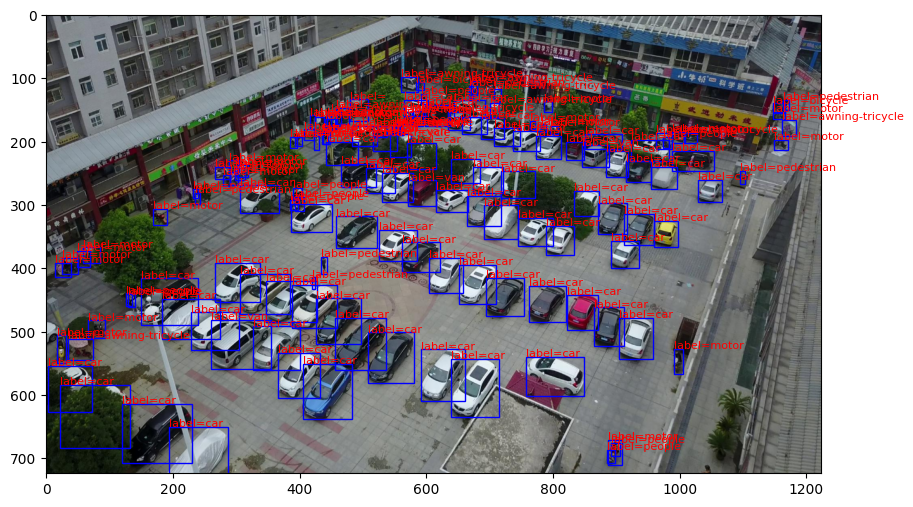

In [ ]:
# plotting the image with bboxes.
img, target = dataset_train[5]
plot_img_bbox(img, target)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
    
    # get number of input features for the classifier
    # in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
      
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# use our dataset and defined transformations
dataset_train = VisDroneDataset(files_dir_train+'/images',files_dir_train+'/annotations', 480, 480, transforms= get_transform(train=True))
dataset_test = VisDroneDataset('/content/images','/content/annotations', 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset_train)*test_split)
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 12

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# Define the hyperparameters
lr = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr,
                            momentum, weight_decay)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size,
                                               gamma)

Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 228MB/s]


In [ ]:
# training for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # model.train()
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/110]  eta: 0:15:35  lr: 0.000051  loss: 17.4353 (17.4353)  bbox_regression: 8.9009 (8.9009)  classification: 8.5344 (8.5344)  time: 8.5038  data: 0.9364  max mem: 541
Epoch: [0]  [ 10/110]  eta: 0:01:37  lr: 0.000509  loss: 16.5664 (16.1300)  bbox_regression: 8.8832 (8.1774)  classification: 7.8276 (7.9526)  time: 0.9786  data: 0.1171  max mem: 555
Epoch: [0]  [ 20/110]  eta: 0:01:01  lr: 0.000967  loss: 13.3550 (14.1610)  bbox_regression: 6.6506 (7.0854)  classification: 7.1270 (7.0755)  time: 0.2925  data: 0.0622  max mem: 555
Epoch: [0]  [ 30/110]  eta: 0:00:43  lr: 0.001426  loss: 11.1515 (13.1900)  bbox_regression: 5.7636 (6.7157)  classification: 5.4587 (6.4743)  time: 0.2956  data: 0.0636  max mem: 555
Epoch: [0]  [ 40/110]  eta: 0:00:32  lr: 0.001884  loss: 10.6184 (12.4958)  bbox_regression: 5.7361 (6.4895)  classification: 4.7788 (6.0063)  time: 0.2324  data: 0.0392  max mem: 555
Epoch: [0]  [ 50/110]  eta: 0:00:24  lr: 0.002342  loss: 9.8984 (11.9427)  bbox_

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.1):   
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
import numpy as np
import torch

# Assuming that `img` is a numpy array with image data
img_tensor = torch.from_numpy(img).to(device)

In [ ]:
model.eval()
with torch.no_grad():
    img_tensor = torch.from_numpy(img).to(device)
    img_tensor = img_tensor.permute(2, 0, 1)  # Permute the dimensions
    prediction = model([img_tensor])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels'])) 

predicted #boxes:  300
real #boxes:  141


EXPECTED OUTPUT


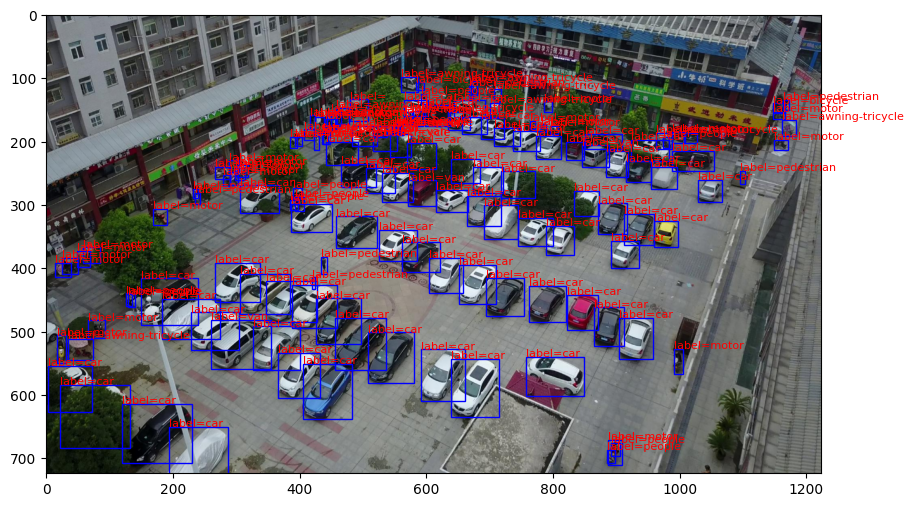

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img_tensor), target)

MODEL OUTPUT


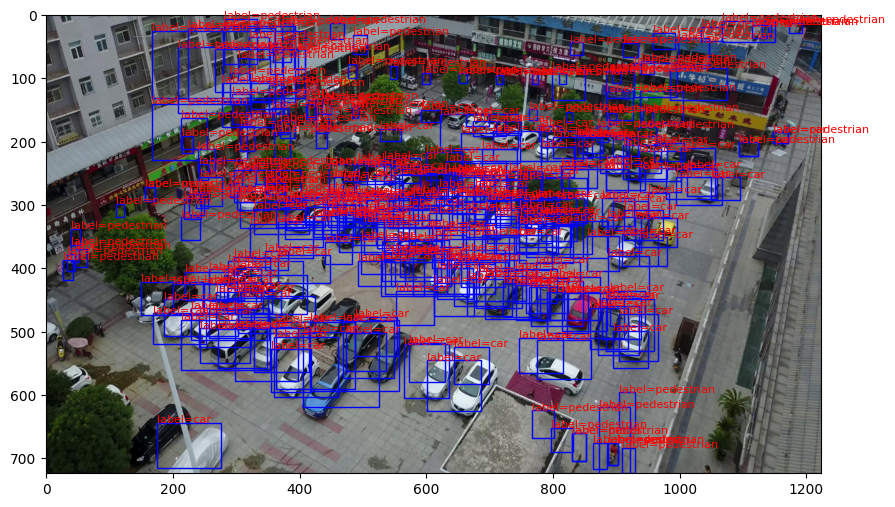

In [ ]:
print('MODEL OUTPUT')
prediction_cpu = {k: v.cpu() for k, v in prediction.items()}
plot_img_bbox(torch_to_pil(img_tensor.cpu()), prediction_cpu)

NMS APPLIED MODEL OUTPUT


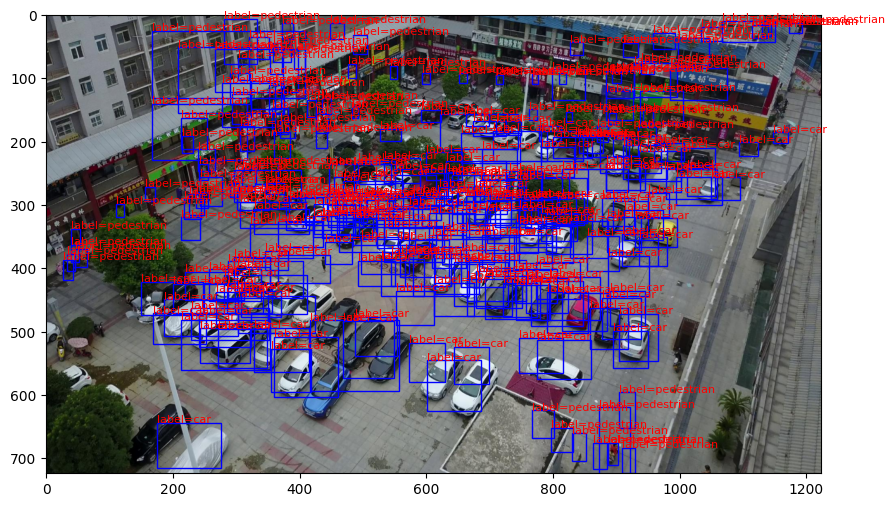

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.5)
nms_prediction_tensors = {k: torch.tensor(v) for k, v in nms_prediction.items()}
nms_prediction_cpu = {k: v.cpu().numpy() for k, v in nms_prediction_tensors.items()}
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img_tensor), nms_prediction_cpu)

EXPECTED OUTPUT



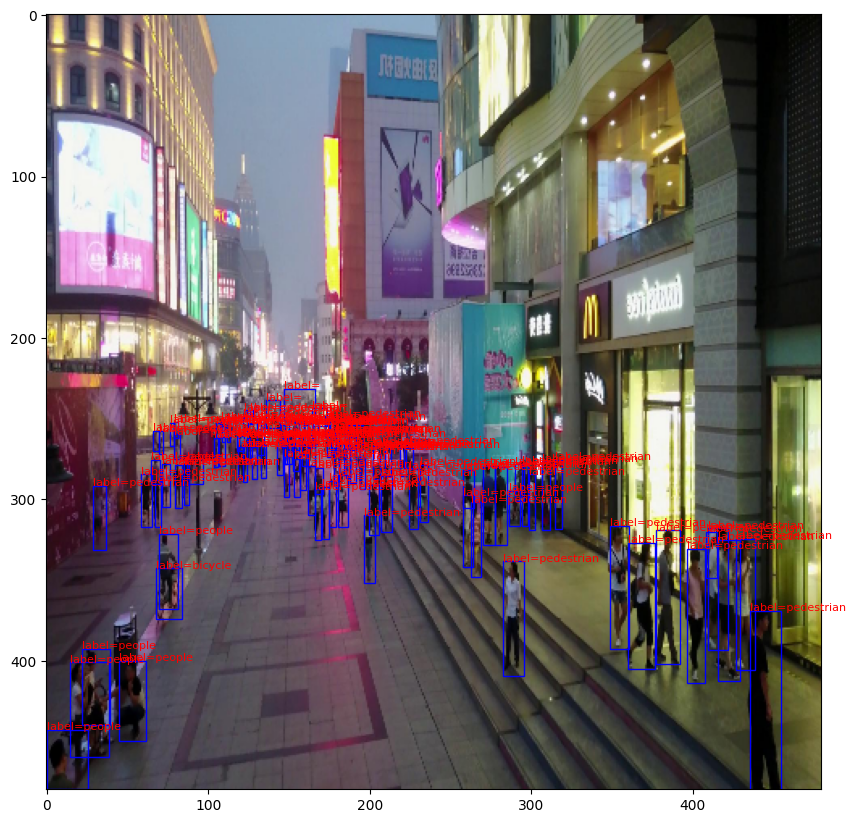

MODEL OUTPUT



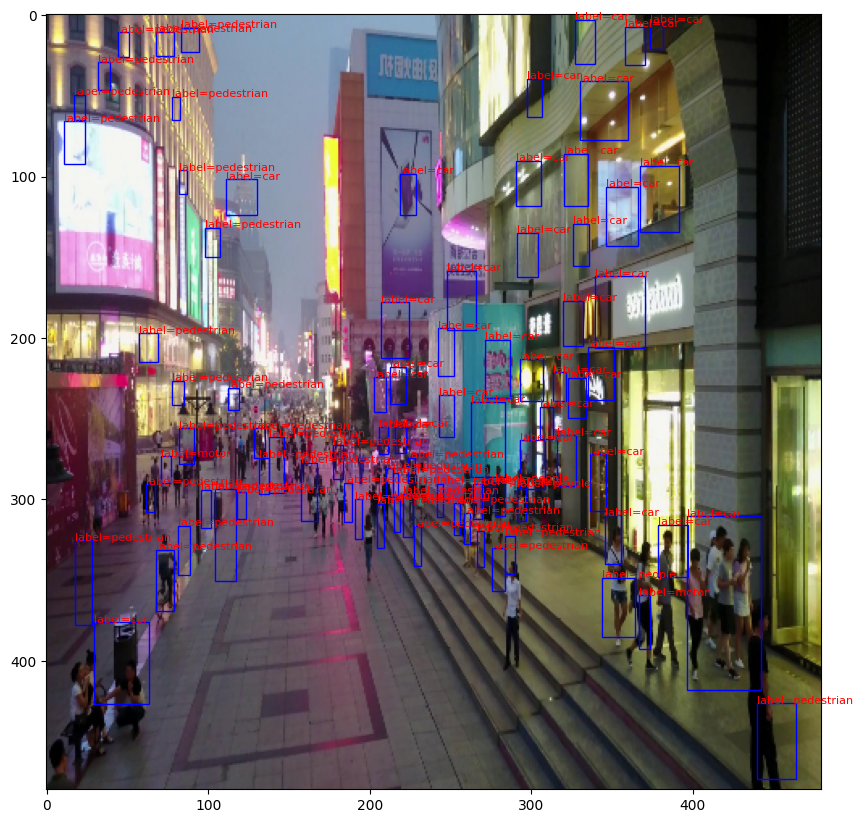

In [ ]:
test_dataset = VisDroneDataset('/content/images','/content/annotations', 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[random.randint(0, len(dataset_test) - 1)]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
nms_prediction_cpu = nms_prediction['boxes'].cpu().numpy()  # transfer the boxes tensor to CPU and convert it to a numpy array
nms_prediction['boxes'] = nms_prediction_cpu  # update the dictionary with the new numpy array

plot_img_bbox(torch_to_pil(img), nms_prediction)